In [1]:
import numpy as np
import sys
import os
import h5py
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px

datadir = ''
figdir  = ''

fname_data = os.path.join(datadir, 'gas_data.hdf5')   

# UPDATED DATA TO BE USED:
# datasets in fname_data: 
#  - data_1point (sample all 14 gas properties at t_formation) (212x14)
#  - data_5point (sample gas properties at 5 times between start of simulation and t_formation) (212x5*14)
#  - data_10point (sample at 10 different times) (212x300*14)
#  - data_20_point (212x20*14)
#  - data_30_point
#  - data_50_point
#  - sink_IDs (212x1)
#  - labels (multiplicity shortly after formation time, before dynamical ejections from stellar systems) (212x1)
#  - labels_final (multiplicity at the end of the simulation)

# Return the labels, gas properties (sampled at 1 up to 50 times in simulation), and sink_IDs.
def loadData(fname_data):
    with h5py.File(fname_data, 'r') as f:
        sink_IDs     = f['sink_IDs'][()]      # (212,)
        labels       = f['labels'][()]        # (212,)
        labels_final = f['labels_final'][()]  # (212,)
        data_1point  = f['data_1point'][()]   # (212, 1x14)
        data_5point  = f['data_5point'][()]   # (212, 5x14)
        data_10point = f['data_10point'][()]  # (212, 10x14)
        data_20point = f['data_20point'][()]  # (212, 20x14)
        data_30point = f['data_30point'][()]  # (212, 30x14)
        data_50point = f['data_50point'][()]  # (212, 50x14)
        
        data = [data_1point, data_5point, data_10point, data_20point, data_30point, data_50point]
        
        # Replace NaN with 0
        for dset in data:
            dset[np.isnan(dset)] = 0.0
            
        # Replace inf with 0 for now.
        for dset in data:
            dset[np.isinf(dset)] = 0.0
            
        n_sinks = len(sink_IDs)
        
    labels       = np.reshape(labels, (n_sinks, 1))
    labels_final = np.reshape(labels_final, (n_sinks, 1))
        
    return labels, labels_final, data, sink_IDs


# Add option to replace labels ['2', '3', '4'] with just '2' to compare single vs. multiple systems.
def getData(fname_data, num_samples='20', use_labels='initial', relabel_multiplicity=False):
    '''
    num_samples = '1', '5', '10', '20', '30', '50'
    use_labels = 'initial' to use labels, 'final' to use labels_final
    '''
    labels_initial, labels_final, data, sink_IDs = loadData(fname_data)
    
    # Decide which multiplicity labels to use (at formation vs. end of simulation).
    if use_labels == 'initial':
        labels = labels_initial
    else:
        labels = labels_final
    
    # Replace higher-order multiplicity labels with '2'.
    if relabel_multiplicity:
        labels[(labels >= 2)] = 2
    
    y = labels
    if num_samples == '1':
        x = data[0]
    elif num_samples =='5':
        x = data[1]
    elif num_samples == '10':
        x = data[2]
    elif num_samples == '20':
        x = data[3]
    elif num_samples == '30':
        x = data[4]
    else:
        x = data[5]
    return x, y


# Load necessary data

In [2]:
x1, y1_2class = getData(fname_data, num_samples='1', use_labels='final', relabel_multiplicity=True) # labels for 2 classes
x30, y30_2class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=True)

pt = PowerTransformer(method= 'yeo-johnson', standardize= True)
x1_trans = pt.fit_transform(x1)
x30_trans = pt.fit_transform(x30)
_, y1_4class = getData(fname_data, num_samples='1', use_labels = 'final', relabel_multiplicity=False) # labels for 4 classes
_, y30_4class = getData(fname_data, num_samples='30', use_labels='final', relabel_multiplicity=False)


# Data preprocessing

/Users/albertzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/albertzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

Text(0, 0.5, '')

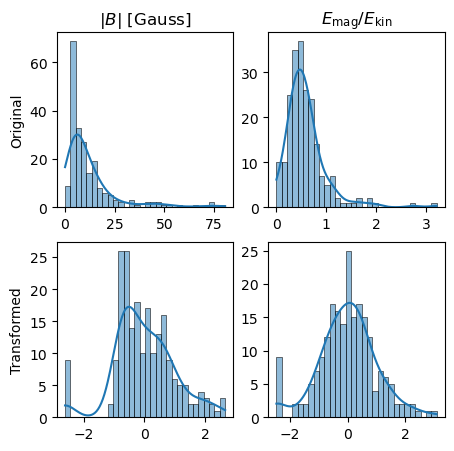

In [3]:
fig1, axs = plt.subplots(2, 2, figsize = [5, 5])

sns.histplot(x1[:, 4], ax=axs[0, 0], bins=30, kde=True) # chose magnetic filed
axs[0, 0].set_ylabel('Original')
axs[0, 0].set_title('$|B|$ [Gauss]')
sns.histplot(x1_trans[:, 4], ax=axs[1, 0], bins=30, kde=True)
axs[1, 0].set_ylabel('Transformed')

#sns.histplot(x1[:, 7], ax=axs[0, 1], bins=30, kde=True)
#axs[0, 1].set_ylabel('')
#axs[0, 1].set_title('$E_{\\rm grav}$')
#sns.histplot(x1_trans[:, 7], ax=axs[1, 1], bins=30, kde=True)
#axs[1, 1].set_ylabel('')

sns.histplot(x1[:, 13], ax=axs[0, 1], bins=30, kde=True)
axs[0, 1].set_ylabel('')
axs[0, 1].set_title('$E_{\\rm mag}/E_{\\rm kin}$')# chose E_mag/E_kin
sns.histplot(x1_trans[:, 13], ax=axs[1, 1], bins=30, kde=True)
axs[1, 1].set_ylabel('')

In [ ]:
fig1.savefig('../figures/dataPrecrocessing.jpg', dpi=300, bbox_inches='tight')

# PCA plot

## Single v.s. Multi

### Feature number $14\times 1$

Text(0.5, 0.98, 'Single v.s. Multiple ')

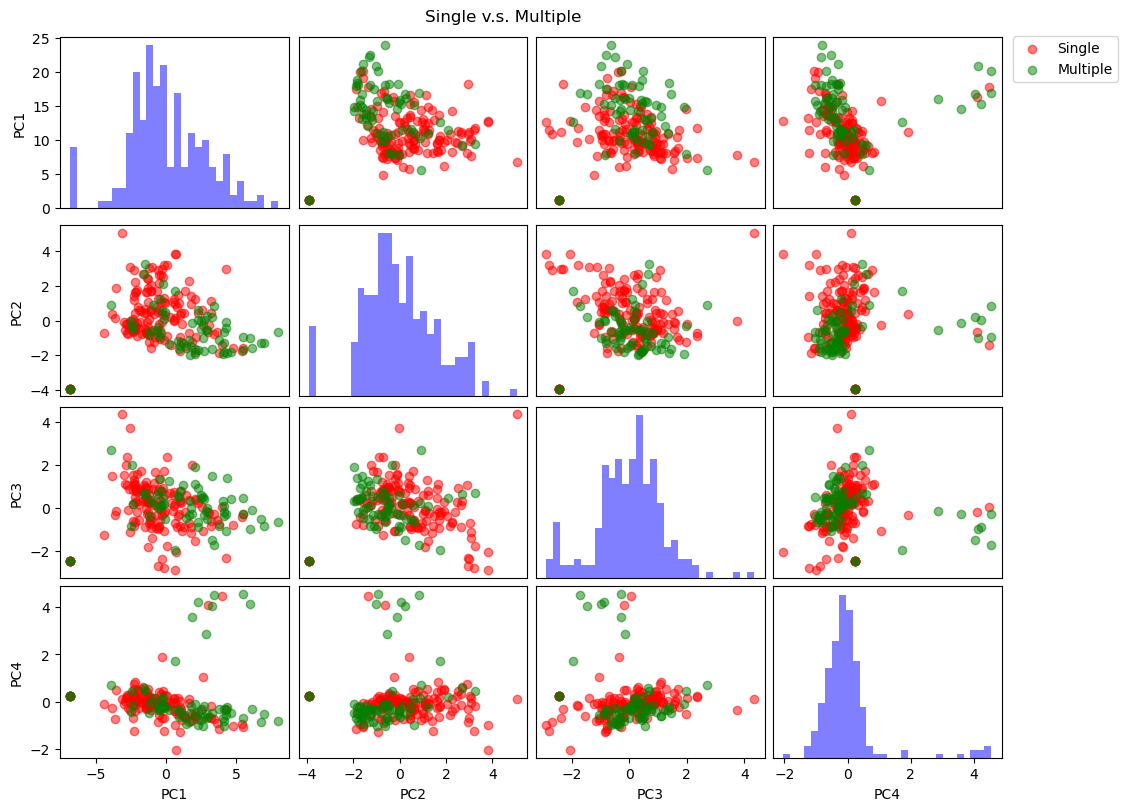

In [25]:
# Perform PCA
pca = PCA(n_components=4)
x1_pca = pca.fit_transform(x1_trans)

# Define colors for each class
colors = ['r', 'g']
labels = ['PC1', 'PC2', 'PC3', 'PC4']
system_labels = ['Single', 'Multiple']

# Create a scatter matrix plot for the first four PCA components
num_pc = x1_pca.shape[1]

fig2, axes = plt.subplots(nrows=num_pc, ncols=num_pc, figsize=(10, 8), layout = 'constrained')
for i in range(num_pc):
    for j in range(num_pc):
        ax = axes[i, j]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == j:
            ax.hist(x1_pca[:, i], bins=30, color='b', alpha=0.5)
            ax.set_ylabel('Frequency')
        else:
            for class_label in np.unique(y1_2class):
                ax.scatter(x1_pca[y1_2class[:, 0] == class_label, j], x1_pca[y1_2class[:, 0] == class_label, i], 
                           color=colors[class_label-1], label= system_labels[class_label - 1], alpha=0.5)
        if j == 0:
            ax.set_ylabel(labels[i])
            ax.get_yaxis().set_visible(True)
        if i == num_pc - 1:
            ax.set_xlabel(labels[j])
            ax.get_xaxis().set_visible(True)

# Add legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig2.legend(handles, labels, loc='upper left', bbox_to_anchor = (1, 0.97))
fig2.suptitle('Single v.s. Multiple ')
#fig.legend()
#fig.legend('asdp,n,nkjkjnkjn')


In [26]:
fig2.savefig('../figures/PCA_1_2class.jpg', dpi=300, bbox_inches='tight')

### Feature number $14\times 30$

Text(0.5, 0.98, 'Single v.s. Multiple ')

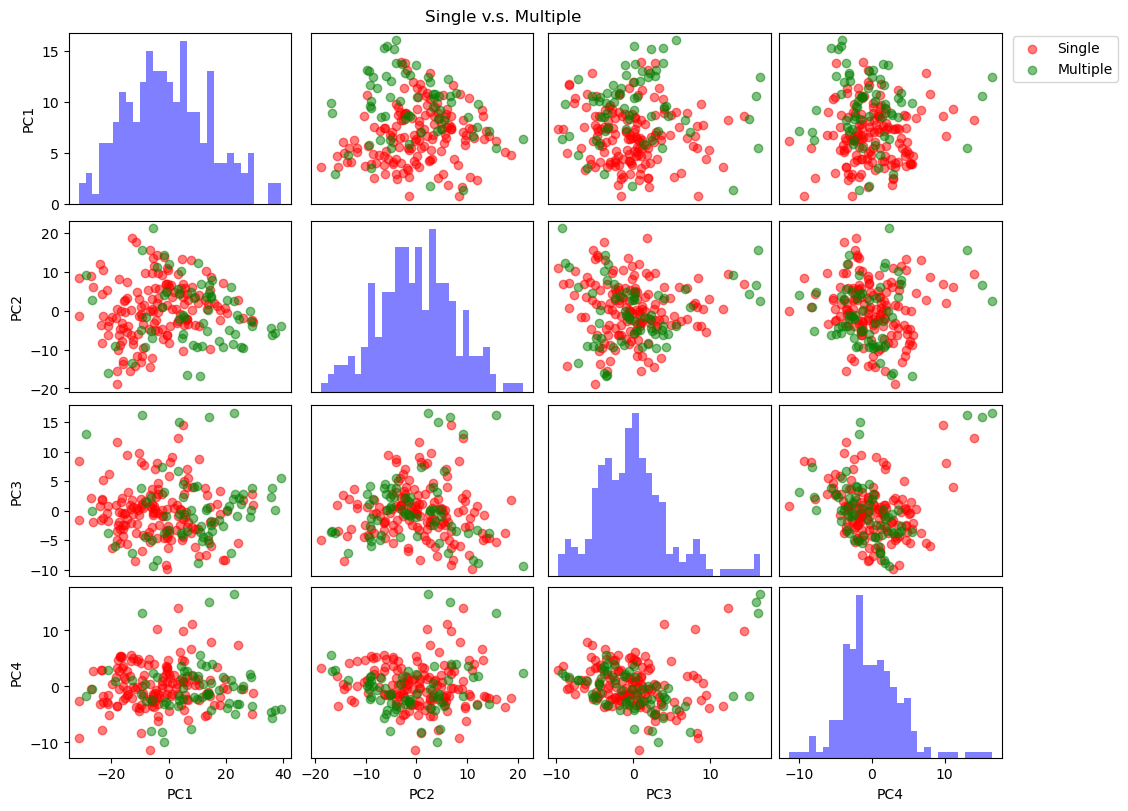

In [39]:
# Perform PCA
pca = PCA(n_components=4)
x30_pca = pca.fit_transform(x30_trans)

# Define colors for each class
colors = ['r', 'g']
labels = ['PC1', 'PC2', 'PC3', 'PC4']
system_labels = ['Single', 'Multiple']

# Create a scatter matrix plot for the first four PCA components
num_pc = x30_pca.shape[1]

fig3, axes = plt.subplots(nrows=num_pc, ncols=num_pc, figsize=(10, 8), layout = 'constrained')
for i in range(num_pc):
    for j in range(num_pc):
        ax = axes[i, j]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == j:
            ax.hist(x30_pca[:, i], bins=30, color='b', alpha=0.5)
            ax.set_ylabel('Frequency')
        else:
            for class_label in np.unique(y30_2class):
                ax.scatter(x30_pca[y30_2class[:, 0] == class_label, j], x30_pca[y30_2class[:, 0] == class_label, i], 
                           color=colors[class_label-1], label= system_labels[class_label - 1], alpha=0.5)
        if j == 0:
            ax.set_ylabel(labels[i])
            ax.get_yaxis().set_visible(True)
        if i == num_pc - 1:
            ax.set_xlabel(labels[j])
            ax.get_xaxis().set_visible(True)

# Add legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig3.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.97))
fig3.suptitle('Single v.s. Multiple ')


In [40]:
fig3.savefig('../figures/PCA_30_2class.jpg', dpi=300, bbox_inches='tight')

## Full classification

### Feature number $14\times 1$

Text(0.5, 0.98, 'Multiplicity 1~4')

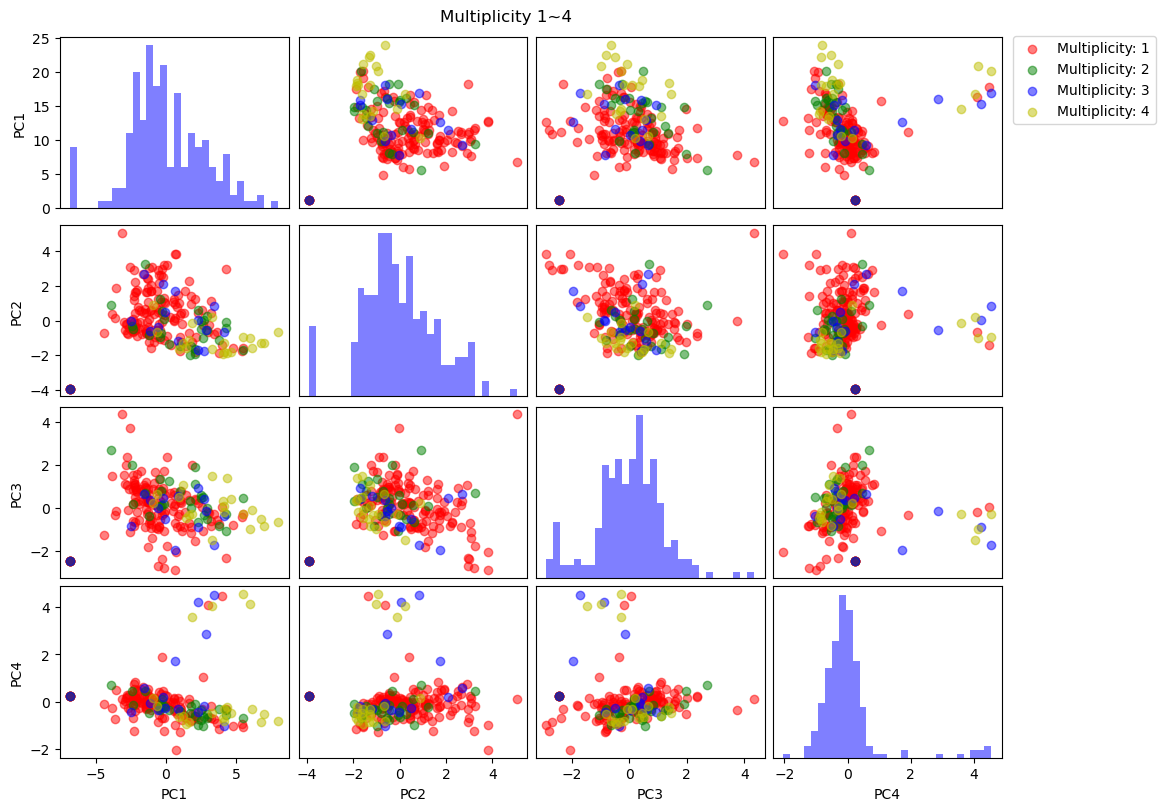

In [41]:
# Perform PCA
pca = PCA(n_components=4)
x1_pca = pca.fit_transform(x1_trans)

# Define colors for each class
colors = ['r', 'g', 'b', 'y']
labels = ['PC1', 'PC2', 'PC3', 'PC4']

# Create a scatter matrix plot for the first four PCA components
num_pc = x1_pca.shape[1]

fig4, axes = plt.subplots(nrows=num_pc, ncols=num_pc, figsize=(10, 8), layout = 'constrained')
for i in range(num_pc):
    for j in range(num_pc):
        ax = axes[i, j]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == j:
            ax.hist(x1_pca[:, i], bins=30, color='b', alpha=0.5)
            ax.set_ylabel('Frequency')
        else:
            for class_label in np.unique(y1_4class):
                ax.scatter(x1_pca[y1_4class[:, 0] == class_label, j], x1_pca[y1_4class[:, 0] == class_label, i], 
                           color=colors[class_label-1], label=': '.join(["Multiplicity", str(class_label)]), alpha=0.5)
        if j == 0:
            ax.set_ylabel(labels[i])
            ax.get_yaxis().set_visible(True)
        if i == num_pc - 1:
            ax.set_xlabel(labels[j])
            ax.get_xaxis().set_visible(True)

# Add legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig4.legend(handles, labels, loc='upper left', bbox_to_anchor = (1, 0.97))
fig4.suptitle('Multiplicity 1~4')
#fig.legend()
#fig.legend('asdp,n,nkjkjnkjn')


In [42]:
fig4.savefig('../figures/PCA_1_4class.jpg', dpi=300, bbox_inches = 'tight')

### Feature numbers $14\times 30$

Text(0.5, 0.98, 'Multiplicity 1~4')

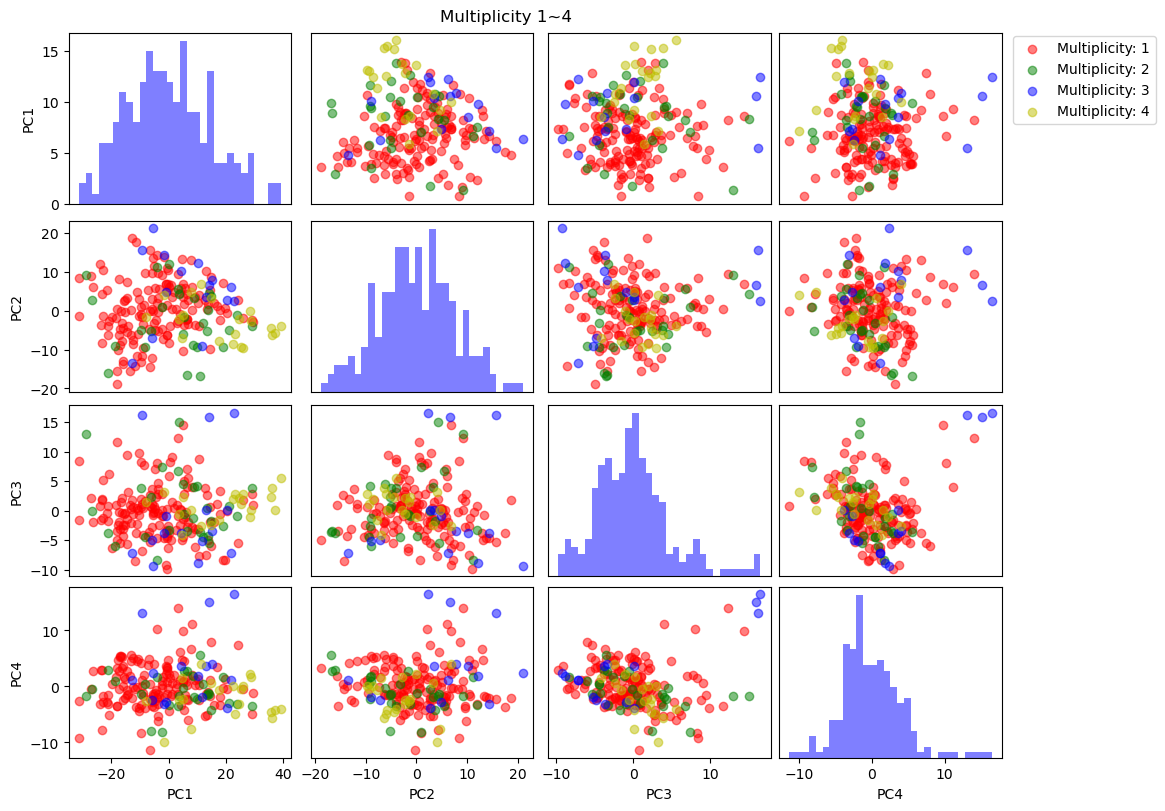

In [44]:
# Perform PCA
pca = PCA(n_components=4)
x30_pca = pca.fit_transform(x30_trans)

# Define colors for each class
colors = ['r', 'g', 'b', 'y']
labels = ['PC1', 'PC2', 'PC3', 'PC4']

# Create a scatter matrix plot for the first four PCA components
num_pc = x30_pca.shape[1]

fig5, axes = plt.subplots(nrows=num_pc, ncols=num_pc, figsize=(10, 8), layout = 'constrained')
for i in range(num_pc):
    for j in range(num_pc):
        ax = axes[i, j]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == j:
            ax.hist(x30_pca[:, i], bins=30, color='b', alpha=0.5)
            ax.set_ylabel('Frequency')
        else:
            for class_label in np.unique(y30_4class):
                ax.scatter(x30_pca[y30_4class[:, 0] == class_label, j], x30_pca[y30_4class[:, 0] == class_label, i], 
                           color=colors[class_label-1], label=': '.join(["Multiplicity", str(class_label)]), alpha=0.5)
        if j == 0:
            ax.set_ylabel(labels[i])
            ax.get_yaxis().set_visible(True)
        if i == num_pc - 1:
            ax.set_xlabel(labels[j])
            ax.get_xaxis().set_visible(True)

# Add legend
handles, labels = axes[0, 1].get_legend_handles_labels()
fig5.legend(handles, labels, loc='upper left', bbox_to_anchor = (1, 0.97))
fig5.suptitle('Multiplicity 1~4')
#fig.legend()
#fig.legend('asdp,n,nkjkjnkjn')


In [45]:
fig5.savefig('../figures/PCA_30_4class.jpg', dpi=300, bbox_inches = 'tight')